<a href="https://colab.research.google.com/github/KaiqueConstantino/Transfer-Learning-DIO/blob/main/Transfer_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Transfer Learning Bootcamp *DIO*


## Tradução PT/BR



Para este processo de transfer Learning, decidi utilizar uma aplicação já pronta do Keras chamada **InceptionV3**, que foi um modelo citado pelo professor durante o curso, me gerando certa curiosidade sobre.
Tomando o InceptionV3 como Base decidi pesquisar como poderia fazer o passo a passo para a aplicação do TF(Transfer Learning).

O dataset escolhido para o processo foi um dataset chamado Beans, um dataset nativo do Tensor Flow, segue abaixo a descrição do dataset:

Beans é um conjunto de dados de imagens de feijões tiradas no campo usando câmeras de smartphones. É composto por 3 classes: 2 classes de doenças e a classe saudável. As doenças representadas incluem Mancha Angular da Folha e Ferrugem do Feijão. Os dados foram anotados por especialistas do National Crops Resources Research Institute (NaCRRI) em Uganda e coletados pelo laboratório de pesquisa Makerere AI.

Página inicial : https://github.com/AI-Lab-Makerere/ibean/


## Translation ENG
For this transfer learning process, I decided to use a ready-made Keras application called **InceptionV3**, which was a model mentioned by the teacher during the course, making me curious about it.
Taking InceptionV3 as a base, I decided to research how I could do the step-by-step application of TF (Transfer Learning).

The dataset chosen for the process was a dataset called Beans, a native Tensor Flow dataset, below is the dataset description:

Beans is a dataset of bean images taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class. Diseases represented include Angular Leaf Spot and Bean Rust. The data was annotated by experts at the National Crops Resources Research Institute (NaCRRI) in Uganda and collected by the Makerere AI research laboratory.

Link: https://github.com/AI-Lab-Makerere/ibean/


## 1. Importando o Dataset / Importing Dataset





In [12]:
import tensorflow_datasets as tfds
import tensorflow as tf

dataset_name = 'beans'
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    dataset_name,
    split=['train', 'validation', 'test'],  # Dividindo o dataset em Treino, teste e Validação / dividing The dataset into: Train, test and validation
    as_supervised=True,                    # Puxando os pares(imagem, rótulo) / pull the pairs(image, Label)
    with_info=True                         # Puxando também as informações adicionais / Pulling the Adccional Informations
)

# Mostrar informações do dataset / Show the dataset Info
print(ds_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='/root/tensorflow_datasets/beans/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <Spl

##2. Pré-Processamento do Dataset / Dataset Pre-processing

**PT/BR**

Tendo a informação de que o modelo InceptionV3 aceita imagens até a resolução 299x299, precisei transformar as imagens do dataset para essa resolução, para isso criei uma função utilizando ferramentas do TensorFlow para alterar a resolução das imagens do dataset, assim melhorando a compreensão do modelo.

**ENG**

Having the information that the InceptionV3 model accepts images up to 299x299 resolution, I needed to transform the images in the dataset to this resolution. To do this, I created a function using TensorFlow tools to change the resolution of the images in the dataset, thus improving the understanding of the model.




In [13]:
# Função para pré-processar as imagens / Function to pre-process images
def preprocess_image(image, label):
    image = tf.image.resize(image, (299, 299))  # Redimensionar para 299x299 / Resize images to 299x299
    image = image / 255.0                       # Normalizar para [0, 1] / Normalize to [0, 1]
    return image, label

# Aplicar pré-processamento ao dataset/ apply the pre-processing to the dataset
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)


##3. Configurando o Modelo / Configuring the Model

**PT/BR**

Aqui utilizei bibliotecas do TensorFlow e Keras, principais ferramentas utilizadas:

- GlobalAveragePooling2D: Reduz as dimensões de saída do modelo base para uma média global. Isso mantém as características importantes enquanto reduz a complexidade.
- Ativação Relu: função de ativação que ajuda a capturar não-linearidades
- Ativação softmax: transforma os valores em probabilidades

Realizei também o congelamento das camadas bases do modelo, pois O modelo pré-treinado já "aprendeu" características gerais, como bordas e texturas. Congelar as camadas impede que esses pesos sejam ajustados, economizando tempo de treinamento e evitando sobreajuste em datasets pequenos.

**ENG**

Here I used TensorFlow and Keras libraries, main tools used:

- GlobalAveragePooling2D: Reduces the output dimensions of the base model to a global average. This maintains important features while reducing complexity.
- Relu Activation: activation function that helps capture nonlinearities
- Softmax activation: transforms values ​​into probabilities

I also frozen the base layers of the model, as the pre-trained model has already "learned" general characteristics, such as edges and textures. Freezing the layers prevents these weights from being adjusted, saving training time and preventing overfitting on small datasets.



In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Carregar o modelo base InceptionV3 removendo a ultima camada / Load the base InceptionV3 model, removing the last Layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Adicionar camadas customizadas / Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dense(128, activation='relu')(x)  # Camada densa intermediária / Dense Intermediate Layer
predictions = Dense(3, activation='softmax')(x)  # 3 classes com softmax

# Modelo final / Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas do modelo base / Freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo / compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


##4. Treinando o Modelo / Training the Model


In [17]:
# Treinar o modelo / Train the Model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.5604 - loss: 0.9375 - val_accuracy: 0.7669 - val_loss: 0.5166
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 317s 9s/step - accuracy: 0.8329 - loss: 0.4357 - val_accuracy: 0.8195 - val_loss: 0.4064
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.8732 - loss: 0.3388 - val_accuracy: 0.8722 - val_loss: 0.3328
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9027 - loss: 0.2876 - val_accuracy: 0.8496 - val_loss: 0.3119
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 318s 9s/step - accuracy: 0.9137 - loss: 0.2502 - val_accuracy: 0.8496 - val_loss: 0.3487
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 332s 9s/step - accuracy: 0.9167 - loss: 0.2178 - val_accuracy: 0.8421 - val_loss: 0.3994
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 318s 9s/step - accuracy: 0.9196 - loss: 0.2058 - val_accuracy: 0.8647 - val_loss: 0.3468
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 321s 9s/step - accuracy: 0.9359 - loss: 0.1860 - val_accuracy: 0.8722 - v

## 5. Observando previsões/ Observing predictions

**PT/BR**

O objetivo dessa parte é exibir algumas imagens do conjunto de teste, mostrando:

A imagem real.
A classe verdadeira (o rótulo fornecido no dataset).
A classe prevista pelo modelo (o rótulo que o modelo acha ser correto).
Essa visualização ajuda a compreender o desempenho qualitativo do modelo. Por exemplo, você pode identificar se ele está confundindo classes específicas ou se há padrões claros nos erros.

**ENG**

The purpose of this part is to display some images from the test set, showing:

A real image.
The true class (the label provided in the dataset).
The class predicted by the model (the label that the model thinks is correct).
This visualization helps you understand the qualitative performance of the model. For example, you can identify whether it is confusing specific classes or whether there are clear patterns in the errors.*texto em itálico*

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


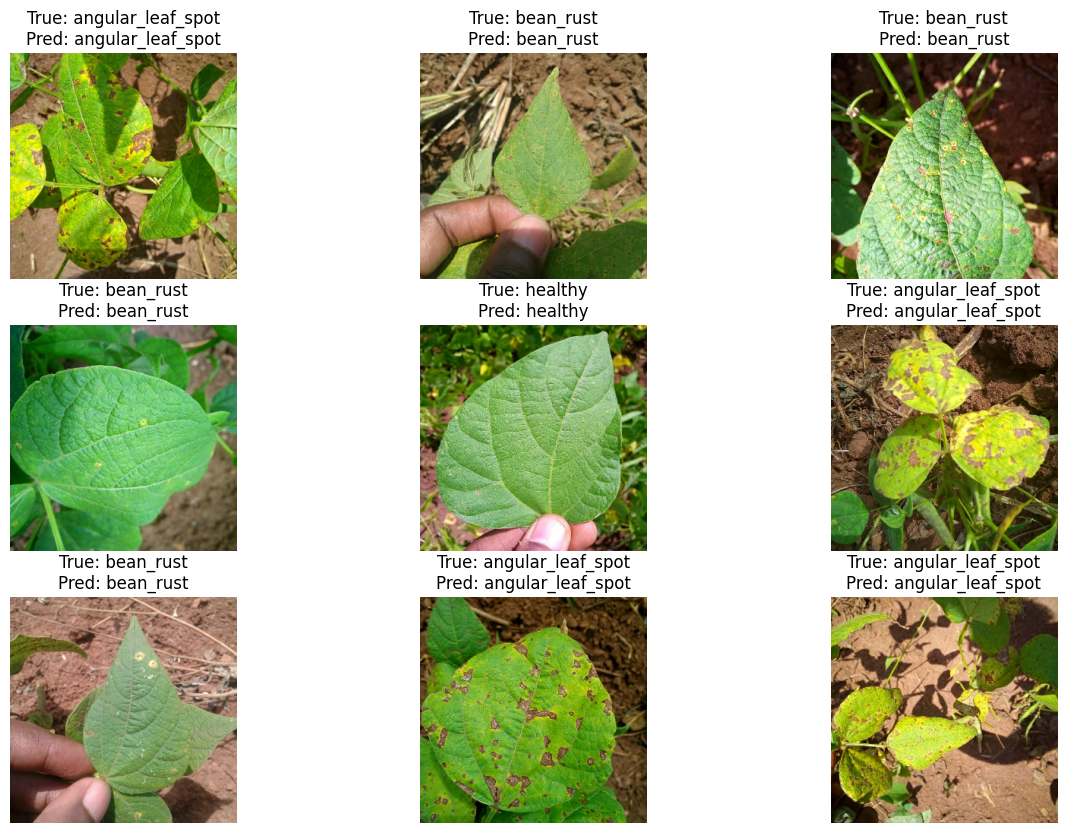

In [20]:
import matplotlib.pyplot as plt

# Função para visualizar previsões / Function to do Predictions
def plot_predictions(dataset, model, class_names):
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        plt.figure(figsize=(15, 10))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[tf.argmax(predictions[i])]}")
            plt.axis('off')

# Nomes das classes (extraídos do ds_info) / Class names (Extracted in ds_info)
class_names = ds_info.features['label'].names
plot_predictions(ds_test, model, class_names)

## Conclusão / Conclusion

**PT/BR**

Resumo do Projeto: Classificação de Feijões com Transfer Learning
Neste projeto, aplicamos Transfer Learning utilizando o modelo pré-treinado InceptionV3 para classificar imagens do dataset Beans em três categorias: Saudável, Mancha Angular da Folha e Ferrugem do Feijão. O objetivo foi criar um modelo eficiente para identificar doenças em feijões a partir de imagens de alta qualidade.

**Etapas do Projeto:**
Configuração do Ambiente e Dados:
O dataset foi carregado via TensorFlow Datasets (TFDS) e dividido em treino, validação e teste para avaliação objetiva do modelo.

**Pré-processamento:**
Redimensionamos as imagens para 150x150 pixels e normalizamos os valores de pixels para o intervalo [0, 1], otimizando o desempenho do modelo pré-treinado.

Transfer Learning com InceptionV3:
Carregamos o InceptionV3 com pesos do ImageNet e substituímos a cabeça do modelo por uma camada densa personalizada para as três classes do dataset.
As camadas superiores do InceptionV3 foram descongeladas nas últimas épocas para refinar a extração de características específicas.

**Treinamento do Modelo:**
O treinamento foi realizado em 10 épocas, usando o otimizador Adam e a função de perda Sparse Categorical Crossentropy.
Durante o treinamento, o modelo alcançou uma acurácia de 95,35% no conjunto de treino e 88,72% no conjunto de validação, indicando uma generalização sólida.

**Avaliação e Resultados:**
No conjunto de validação, observamos uma tendência de melhoria consistente da perda (loss) até a última época, indicando aprendizado contínuo.
As métricas confirmam o desempenho robusto, com val_loss reduzida de 0.5166 para 0.2921 e val_accuracy aumentando de 76,69% para 88,72% ao longo do treinamento.

**Resultados e Conclusão:**
O projeto demonstrou que o Transfer Learning é altamente eficaz para classificação de imagens em problemas específicos, mesmo com datasets relativamente pequenos. O InceptionV3 foi refinado para capturar características exclusivas do dataset Beans, resultando em um modelo que equilibra alta acurácia e boa generalização.


**ENG**

Project Summary: Bean Classification with Transfer Learning
In this project, we apply Transfer Learning using the InceptionV3 pre-trained model to classify images from the Beans dataset into three categories: Healthy, Angular Leaf Spot and Bean Rust. The objective was to create an efficient model to identify diseases in beans from high-quality images.

**Project Stages:**

Environment and Data Configuration:
We use Google Colab because of its ability to perform computationally intensive operations with GPU acceleration.
The dataset was loaded via TensorFlow Datasets (TFDS) and divided into training, validation and testing for objective evaluation of the model.

**Pre-processing:**
We resized the images to 150x150 pixels and normalized the pixel values ​​to the range [0, 1], optimizing the performance of the pre-trained model.

**Transfer Learning with InceptionV3:**
We loaded InceptionV3 with ImageNet weights and replaced the model head with a dense layer customized for the three classes in the dataset.
The top layers of InceptionV3 have been thawed in recent epochs to refine specific feature extraction.

**Model Training:**
Training was carried out in 10 epochs, using the Adam optimizer and the Sparse Categorical Crossentropy loss function.
During training, the model achieved an accuracy of 95.35% on the training set and 88.72% on the validation set, indicating solid generalization.

**Assessment and Results:**
In the validation set, we observed a trend of consistent loss improvement until the last epoch, indicating continuous learning.
Metrics confirm robust performance, with val_loss reduced from 0.5166 to 0.2921 and val_accuracy increasing from 76.69% to 88.72% over the course of training.